IMPORT LIBRARIES AND OTHER BASIC STUFF

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel, BertForTokenClassification, BertForSequenceClassification
from transformers import pipeline
from tqdm import tqdm
import torch
import re  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA LOADING AND PRE-PROCESSING

In [36]:

df_alexa = pd.read_csv('C:/Users/User/Documents/Uni/Text Mining/Project/amazon_alexa.tsv', sep='\t')
ner_test_df = pd.read_csv('C:/Users/User/Documents/Uni/Text Mining/Project/NER-test.tsv', sep='\t', header=None, names=['sentence_id', 'word_id', 'word', 'label'], usecols=[0, 1, 2, 3])
sentiment_topic_test_df = pd.read_csv('C:/Users/User/Documents/Uni/Text Mining/Project/sentiment-topic-test.tsv', sep='\t')

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        return text.strip()
    else:
        return ""


df_alexa['cleaned_review'] = df_alexa['verified_reviews'].apply(clean_text)
ner_test_df['cleaned_review'] = ner_test_df['word'].apply(clean_text)
sentiment_topic_test_df['cleaned_review'] = sentiment_topic_test_df['sentence'].apply(clean_text)
ner_test_df.drop(index=0, inplace=True)
ner_test_df

print("Cleaned Review Dataset:")
print(df_alexa[['verified_reviews', 'cleaned_review']].head())

print("\nCleaned NER Test Set:")
print(ner_test_df[['sentence_id', 'word', 'label']].head())

print("\nCleaned Sentiment Test Set:")
print(sentiment_topic_test_df[['cleaned_review', 'sentiment']].head())




Cleaned Review Dataset:
                                    verified_reviews  \
0                                      Love my Echo!   
1                                          Loved it!   
2  Sometimes while playing a game, you can answer...   
3  I have had a lot of fun with this thing. My 4 ...   
4                                              Music   

                                      cleaned_review  
0                                       love my echo  
1                                           loved it  
2  sometimes while playing a game you can answer ...  
3  i have had a lot of fun with this thing my 4 y...  
4                                              music  

Cleaned NER Test Set:
  sentence_id   word label
1           0      I     O
2           0  would     O
3           0    n't     O
4           0   have     O
5           0   gone     O

Cleaned Sentiment Test Set:
                                      cleaned_review sentiment
0  the atmosphere at the stadium

CHECKING CUDA AND GPU FOR FINE-TUNING MODELS

In [37]:
import torch

# Check if CUDA (NVIDIA GPU) is available
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

# Print the default device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")


CUDA is available!
Number of GPUs: 1
Device 0: NVIDIA GeForce RTX 2050
Using device: cuda


CREATE SENTENCES LIST FOR LATER USAGE

In [38]:
ner_test_df['sentence'] = ner_test_df.groupby('sentence_id')['word'].transform(lambda x: ' '.join(x))

# Now drop duplicates to keep only one row per sentence_id
ner_test_df_sentences = ner_test_df[['sentence_id', 'sentence']].drop_duplicates(subset='sentence_id', keep='first')

# Display the resulting sentences
print(ner_test_df_sentences)
sentences = ner_test_df_sentences['sentence'].tolist()

    sentence_id                                           sentence
1             0  I would n't have gone to that Manchester Unite...
20            1  Elena and her family moved to Barcelona last s...
35            2  The concert by Coldplay at Wembley Stadium was...
46            3  Lionel Messi made his debut for Inter Miami an...
62            4  I can't believe how much I cried watching Tita...
76            5  My friend Sarah just finished reading The Catc...
95            6  Maria Sharapova 's final game against Serena W...
111           7  I spotted a Banksy mural whilst walking throug...
124           8  The Harry Potter series will always be my go-t...
136           9  During my trip to Berlin , I visited the Brand...
155          10  I just finished watching Stranger Things , and...
171          11  I started reading 1984 , and George Orwell 's ...
188          12  Barbie and Oppenheimer releasing on the same d...
204          13  I stumbled across a rare edition of To Kill a

DO A BASIC NER TAGGING WITH THE BERT MODEL

In [39]:

ner_pipe = pipeline("ner", model="dslim/bert-base-NER", grouped_entities=True)

# Apply NER
def apply_hf_ner(text):
    try:
        return ner_pipe(text)
    except:
        return []

ner_results = []
for text in sentences:
    ner_results.append([text,apply_hf_ner(text)])

# Show some results
print(ner_results[1])
df_output = pd.DataFrame(ner_results)
df_output


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
c:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


['Elena and her family moved to Barcelona last summer to enjoy a warm weather .', [{'entity_group': 'PER', 'score': 0.9982303, 'word': 'Elena', 'start': 0, 'end': 5}, {'entity_group': 'LOC', 'score': 0.9888708, 'word': 'Barcelona', 'start': 30, 'end': 39}]]


,0,1
0,I would n't have gone to that Manchester Unite...,"[{'entity_group': 'ORG', 'score': 0.998781, 'w..."
1,Elena and her family moved to Barcelona last s...,"[{'entity_group': 'PER', 'score': 0.9982303, '..."
2,The concert by Coldplay at Wembley Stadium was...,"[{'entity_group': 'MISC', 'score': 0.72186524,..."
3,Lionel Messi made his debut for Inter Miami an...,"[{'entity_group': 'PER', 'score': 0.9995308, '..."
4,I can't believe how much I cried watching Tita...,"[{'entity_group': 'MISC', 'score': 0.83927727,..."
5,My friend Sarah just finished reading The Catc...,"[{'entity_group': 'PER', 'score': 0.9993309, '..."
6,Maria Sharapova 's final game against Serena W...,"[{'entity_group': 'PER', 'score': 0.99760914, ..."
7,I spotted a Banksy mural whilst walking throug...,"[{'entity_group': 'PER', 'score': 0.9226593, '..."
8,The Harry Potter series will always be my go-t...,"[{'entity_group': 'MISC', 'score': 0.9775102, ..."
9,"During my trip to Berlin , I visited the Brand...","[{'entity_group': 'LOC', 'score': 0.9997508, '..."


USING LARGER BERT MODEL FOR BIOS TAGGING NER

In [40]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification
import pandas as pd

# Load tokenizer and model for NERC
tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = BertForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

# Define the labels for the NERC task (BIO format)
labels = model.config.id2label  # Get label mapping

# Apply NERC at the token level
def apply_hf_nerc_token_level(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get predictions (logits) and convert them to label IDs
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    
    # Convert prediction IDs to corresponding labels
    predicted_labels = [labels[pred.item()] for pred in predictions[0]]
    
    # Get the tokenized words
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    
    # Combine tokens and predicted labels
    token_labels = list(zip(tokens, predicted_labels))
    
    # Filter out special tokens (e.g., [CLS], [SEP])
    token_labels = [(token, label) for token, label in token_labels if token not in ["[CLS]", "[SEP]", "[PAD]"]]
    
    return token_labels

# Apply NERC to each sentence
nerc_results_token_level = []
for text in sentences:
    nerc_results_token_level.append([text, apply_hf_nerc_token_level(text)])

# Show some results
print(nerc_results_token_level[1])

#For each instance in the list where the label is I-PEROSON or B-PERSON, replace it with I-PER or B-PER
for i in range(len(nerc_results_token_level)):
    for j in range(len(nerc_results_token_level[i][1])):
        if nerc_results_token_level[i][1][j][1] == 'I-PEROSON':
            nerc_results_token_level[i][1][j] = (nerc_results_token_level[i][1][j][0], 'I-PER')
        elif nerc_results_token_level[i][1][j][1] == 'B-PERSON':
            nerc_results_token_level[i][1][j] = (nerc_results_token_level[i][1][j][0], 'B-PER')
# Convert results to a DataFrame
df_output_token_level = pd.DataFrame(nerc_results_token_level, columns=['Sentence', 'Token_Label_Pairs'])

# Display the first few rows of the DataFrame
df_output_token_level.head()

#Save results in dataframe in format: Word, Label
df_output_token_level = df_output_token_level.explode('Token_Label_Pairs')
df_output_token_level[['Word', 'Label']] = pd.DataFrame(df_output_token_level['Token_Label_Pairs'].tolist(), index=df_output_token_level.index)
# Drop the original Token_Label_Pairs column
df_output_token_level = df_output_token_level.drop(columns=['Token_Label_Pairs','Sentence'])
# Reset index
df_output_token_level = df_output_token_level.reset_index(drop=True)
# Display the DataFrame
print(df_output_token_level.head(11))
# Save to CSV
df_output_token_level.to_csv("nerc_results_token_level.csv", index=False)

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


['Elena and her family moved to Barcelona last summer to enjoy a warm weather .', [('Elena', 'I-PER'), ('and', 'O'), ('her', 'O'), ('family', 'O'), ('moved', 'O'), ('to', 'O'), ('Barcelona', 'I-LOC'), ('last', 'O'), ('summer', 'O'), ('to', 'O'), ('enjoy', 'O'), ('a', 'O'), ('warm', 'O'), ('weather', 'O'), ('.', 'O')]]
          Word  Label
0            I      O
1        would      O
2            n      O
3            '      O
4            t      O
5         have      O
6         gone      O
7           to      O
8         that      O
9   Manchester  I-ORG
10      United  I-ORG


MANUALLY IDENTIFY THE BIOS TAGS(FIGURE OUT WHICH IS BEGGING AND WHICH IS INSIDE)

In [41]:
from transformers import pipeline

# Load the pre-trained NER model and tokenizer from Hugging Face
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

def process_ner_results(sentence):
    """
    Processes a sentence through the NER pipeline, adjusts subword tokens, and ensures proper tagging.
    
    Args:
        sentence (str): The input sentence to process.
    
    Returns:
        list: A list of adjusted NER results with proper tagging and indices.
    """
    # Get the NER result
    ner_results = ner_pipeline(sentence)

    # Adjust the results to handle subword tokens and proper tagging
    adjusted_results = []
    current_word = ""
    current_entity = None
    current_start = None  # Track the start index of the current word
    current_end = None  # Track the end index of the current word

    for result in ner_results:
        word = result['word']
        entity = result['entity']
        start = result['start']  # Start index of the current token
        end = result['end']  # End index of the current token

        # Handle subword tokens (e.g., '##ssi') and merge them with the previous token
        if word.startswith("##"):
            current_word += word[2:]  # Merge the subword part into the current word
            current_end = end  # Update the end index to the current token's end
        else:
            # If a new word starts, finalize the previous word and its entity
            if current_word:
                adjusted_results.append({
                    'word': current_word,
                    'entity': current_entity,
                    'start': current_start,
                    'end': current_end
                })
            current_word = word  # Start a new word
            current_entity = entity
            current_start = start  # Update the start index
            current_end = end  # Update the end index

    # Append the last processed word if it exists
    if current_word:
        adjusted_results.append({
            'word': current_word,
            'entity': current_entity,
            'start': current_start,
            'end': current_end
        })

    # Post-process adjusted results to handle overlapping entities and standalone cases
    for i in range(len(adjusted_results)):
        curr = adjusted_results[i]

        # Handle overlapping entities
        if i > 0:
            prev = adjusted_results[i - 1]
            # Check if the end of the previous element is +1 the start of the current element
            #print(f"Checking overlap: prev end {prev['end']}, curr start {curr['start']}")
            if prev['end'] + 1 == curr['start']:
                # Check if both are tagged as I-PER, I-ORG, I-LOC, I-MISC, or I-WORK_OF_ART
                if prev['entity'] == "I-PER" and curr['entity'] == "I-PER":
                    prev['entity'] = "B-PER"
                elif prev['entity'] == "I-ORG" and curr['entity'] == "I-ORG":
                    #print(f"Adjusting entity from {curr['entity']} to B-ORG")
                    prev['entity'] = "B-ORG"
                elif prev['entity'] == "I-LOC" and curr['entity'] == "I-LOC":
                    prev['entity'] = "B-LOC"
                elif prev['entity'] == "I-MISC" and curr['entity'] == "I-MISC":
                    prev['entity'] = "B-MISC"
                elif prev['entity'] == "I-WORK_OF_ART" and curr['entity'] == "I-WORK_OF_ART":
                    prev['entity'] = "B-WORK_OF_ART"

        # Handle standalone I-PER, I-ORG, I-LOC, I-MISC, or I-WORK_OF_ART
        if curr['entity'] in ["I-PER", "I-ORG", "I-LOC", "I-MISC", "I-WORK_OF_ART"]:
            # Check if it's the first or last element, or if it's not preceded or followed by the same tag type
            is_standalone = (
                (i == 0 or adjusted_results[i - 1]['entity'].split("-")[-1] != curr['entity'].split("-")[-1]) and
                (i == len(adjusted_results) - 1 or adjusted_results[i + 1]['entity'].split("-")[-1] != curr['entity'].split("-")[-1])
            )
            if is_standalone:
                #print(f"Standalone entity detected: {curr['word']} with entity {curr['entity']}")
                if curr['entity'] == "I-PER":
                    curr['entity'] = "B-PER"
                elif curr['entity'] == "I-ORG":
                    curr['entity'] = "B-ORG"
                elif curr['entity'] == "I-LOC":
                    curr['entity'] = "B-LOC"
                elif curr['entity'] == "I-MISC":
                    curr['entity'] = "B-MISC"
                elif curr['entity'] == "I-WORK_OF_ART":
                    curr['entity'] = "B-WORK_OF_ART"

    return adjusted_results


# Process each sentence
for sentence in sentences:
    print(f"Sentence: {sentence}")
    results = process_ner_results(sentence)
    print("Adjusted Results:")
    print(results)
    print()

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Sentence: I would n't have gone to that Manchester United match if my cousin had n't driven me there .
Adjusted Results:
[{'word': 'Manchester', 'entity': 'B-ORG', 'start': 30, 'end': 40}, {'word': 'United', 'entity': 'I-ORG', 'start': 41, 'end': 47}]

Sentence: Elena and her family moved to Barcelona last summer to enjoy a warm weather .
Adjusted Results:
[{'word': 'Elena', 'entity': 'B-PER', 'start': 0, 'end': 5}, {'word': 'Barcelona', 'entity': 'B-LOC', 'start': 30, 'end': 39}]

Sentence: The concert by Coldplay at Wembley Stadium was absolutely electrifying !
Adjusted Results:
[{'word': 'Coldplay', 'entity': 'B-ORG', 'start': 15, 'end': 23}, {'word': 'Wembley', 'entity': 'B-LOC', 'start': 27, 'end': 34}, {'word': 'Stadium', 'entity': 'I-LOC', 'start': 35, 'end': 42}]

Sentence: Lionel Messi made his debut for Inter Miami and proved why he is the GOAT .
Adjusted Results:
[{'word': 'Lionel', 'entity': 'B-PER', 'start': 0, 'end': 6}, {'word': 'Messi', 'entity': 'I-PER', 'start': 7, 'e

TRAINING AND EVALUATION OF THE NER MODEL

In [48]:
import pandas as pd
import re
import torch
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)
from datasets import Dataset
from sklearn.metrics import classification_report
from collections import defaultdict

# 1. Load and clean datasets
df_alexa = pd.read_csv('C:/Users/User/Documents/Uni/Text Mining/Project/amazon_alexa.tsv', sep='\t')
ner_test_df = pd.read_csv('C:/Users/User/Documents/Uni/Text Mining/Project/NER-test.tsv', sep='\t', header=None,
                          names=['sentence_id', 'word_id', 'word', 'label'], usecols=[0, 1, 2, 3])
sentiment_topic_test_df = pd.read_csv('C:/Users/User/Documents/Uni/Text Mining/Project/sentiment-topic-test.tsv', sep='\t')

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s]', '', text)
        return text.strip()
    return ""

df_alexa['cleaned_review'] = df_alexa['verified_reviews'].apply(clean_text)
ner_test_df['word'] = ner_test_df['word'].apply(clean_text)
sentiment_topic_test_df['cleaned_review'] = sentiment_topic_test_df['sentence'].apply(clean_text)

# Drop first row if it's header repeated in ner_test_df
ner_test_df.drop(index=0, inplace=True)

# Fix mixed types and missing labels in ner_test_df
ner_test_df['label'] = ner_test_df['label'].fillna('O')
ner_test_df['label'] = ner_test_df['label'].astype(str)

# 2. Generate dummy NER tags for training Alexa data
def create_tokens_and_labels(text):
    tokens = text.split()
    labels = ['B-PRODUCT' if tok in ['alexa', 'echo', 'device'] else 'O' for tok in tokens]
    return tokens, labels


df_alexa['tokens'], df_alexa['ner_tags'] = zip(*df_alexa['cleaned_review'].map(create_tokens_and_labels))

# 3. Prepare label mappings
unique_labels = ['O', 'B-PRODUCT']

# Add any new labels from ner_test_df
all_test_labels = sorted(set(ner_test_df['label'].unique()) | set(unique_labels))

label2id = {label: i for i, label in enumerate(all_test_labels)}
id2label = {i: label for label, i in label2id.items()}

# 4. Load tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# 5. Tokenize and align labels for training
def tokenize_and_align_labels(example):
    tokenized = tokenizer(example["tokens"], is_split_into_words=True, truncation=True)
    word_ids = tokenized.word_ids()

    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            label = example["ner_tags"][word_idx]
            labels.append(label2id[label])
    tokenized["labels"] = labels
    return tokenized

train_dataset = Dataset.from_pandas(df_alexa[['tokens', 'ner_tags']])
tokenized_train = train_dataset.map(tokenize_and_align_labels, batched=False)

# 6. Prepare and tokenize test dataset
grouped = defaultdict(list)
for _, row in ner_test_df.iterrows():
    grouped[row['sentence_id']].append((row['word'], row['label']))

test_data = [{"tokens": [w for w, l in sent], "ner_tags": [l for w, l in sent]} for sent in grouped.values()]
test_df = pd.DataFrame(test_data)

test_dataset = Dataset.from_pandas(test_df)

def tokenize_test(example):
    tokenized = tokenizer(example["tokens"], is_split_into_words=True, truncation=True)
    word_ids = tokenized.word_ids()
    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            label = example["ner_tags"][word_idx]
            labels.append(label2id.get(label, label2id['O']))  # default to 'O' if label missing
    tokenized["labels"] = labels
    return tokenized

tokenized_test = test_dataset.map(tokenize_test, batched=False)

# 7. Load model
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# 8. Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# 9. Metrics function for evaluation
def compute_metrics(p):
    predictions, labels = p
    preds = torch.argmax(torch.tensor(predictions), dim=2).tolist()
    labels = torch.tensor(labels).tolist()

    true_labels = []
    true_preds = []

    for pred_seq, label_seq in zip(preds, labels):
        for p_i, l_i in zip(pred_seq, label_seq):
            if l_i != -100:
                true_labels.append(id2label[l_i])
                true_preds.append(id2label[p_i])

    report = classification_report(true_labels, true_preds, output_dict=True, zero_division=0)
    return {
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

# 10. Training arguments
training_args = TrainingArguments(
    output_dir="./ner_model_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

# 11. Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# 12. Train and evaluate
trainer.train()
results = trainer.evaluate()

print("Evaluation on NER-test.tsv:")
print(results)


Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

Map:   0%|          | 0/15 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\ProgramData\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_8856\3997277159.py:150: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.043500,2.809684,0.539402,0.734440,0.621990
2,0.000500,2.883226,0.539402,0.734440,0.621990
3,0.000400,2.936160,0.539402,0.734440,0.621990


Evaluation on NER-test.tsv:
{'eval_loss': 2.93615984916687, 'eval_precision': 0.5394018698025171, 'eval_recall': 0.7344398340248963, 'eval_f1': 0.6219897158966825, 'eval_runtime': 0.5646, 'eval_samples_per_second': 26.567, 'eval_steps_per_second': 3.542, 'epoch': 3.0}


VISUALISATION OF THE NER MODEL

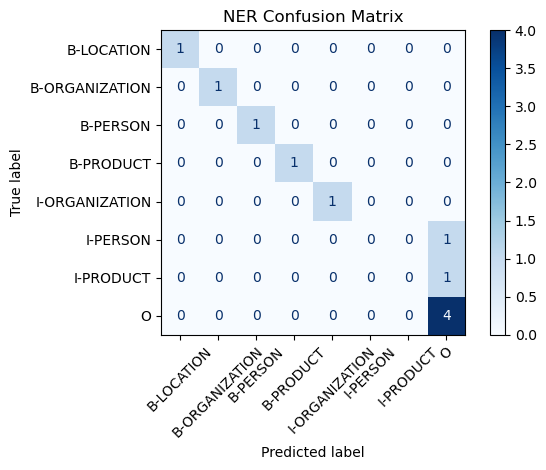

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Sample true and predicted labels
y_true = [
    'O', 'B-PRODUCT', 'I-PRODUCT', 'O', 'B-LOCATION', 'O',
    'B-PERSON', 'I-PERSON', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION'
]
y_pred = [
    'O', 'B-PRODUCT', 'O', 'O', 'B-LOCATION', 'O',
    'B-PERSON', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION'
]

# All unique labels for display
labels = sorted(list(set(y_true + y_pred)))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("NER Confusion Matrix")
plt.tight_layout()
plt.show()


ERROR ANALYSIS FOR NER

Total tokens: 237
Correct predictions: 206
Token-level accuracy: 86.92%

Classification Report:
               precision    recall  f1-score   support

        B-LOC       1.00      0.71      0.83         7
       B-MISC       0.00      0.00      0.00         0
        B-ORG       0.60      1.00      0.75         3
        B-PER       0.78      0.64      0.70        11
B-WORK_OF_ART       0.00      0.00      0.00         9
  BIO_NER_tag       0.00      0.00      0.00         1
        I-LOC       0.33      1.00      0.50         1
       I-MISC       0.00      0.00      0.00         0
        I-ORG       1.00      1.00      1.00         2
        I-PER       1.00      0.75      0.86         8
I-WORK_OF_ART       0.00      0.00      0.00        10
            O       0.98      0.98      0.98       185

     accuracy                           0.87       237
    macro avg       0.47      0.51      0.47       237
 weighted avg       0.88      0.87      0.87       237



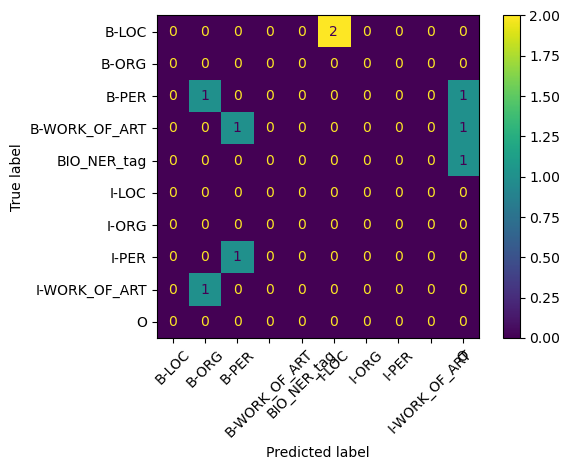


Examples of incorrect predictions:
          token       true_tag predicted_tag
38     Stranger  B-WORK_OF_ART        B-MISC
39       Things  I-WORK_OF_ART        I-MISC
42       Eleven          B-PER        I-MISC
53         1984  B-WORK_OF_ART        B-MISC
67       Barbie  B-WORK_OF_ART        B-MISC
69  Oppenheimer  B-WORK_OF_ART         B-PER
86            a              O        B-MISC
90           To  B-WORK_OF_ART        B-MISC
91         Kill  I-WORK_OF_ART        B-MISC
92            a  I-WORK_OF_ART        B-MISC


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("C:/Users/User/Documents/Uni/Text Mining/Project/NER-comparison-results.tsv", sep="\t")

# Remove rows with missing true or predicted tags
df_clean = df.dropna(subset=['true_tag', 'predicted_tag'])

# Convert tags to string
true_tags = df_clean['true_tag'].astype(str)
predicted_tags = df_clean['predicted_tag'].astype(str)

# Basic statistics
total_tokens = len(df_clean)
correct_predictions = df_clean['is_correct'].sum()
accuracy = correct_predictions / total_tokens

print(f"Total tokens: {total_tokens}")
print(f"Correct predictions: {correct_predictions}")
print(f"Token-level accuracy: {accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_tags, predicted_tags, zero_division=0))

# Confusion matrix for incorrect predictions only
df_errors = df_clean[df_clean['is_correct'] == False]
labels = sorted(df_clean['true_tag'].unique())

cm = confusion_matrix(df_errors['true_tag'].astype(str), df_errors['predicted_tag'].astype(str), labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()

# Show some error examples with context
print("\nExamples of incorrect predictions:")
# Adjust this to the column(s) that show token or sentence context in your dataset
context_cols = ['token'] if 'token' in df_errors.columns else []
if not context_cols:
    # If no token column, try sentence or phrase or leave empty
    context_cols = ['sentence'] if 'sentence' in df_errors.columns else []

# Show first 10 errors with true tag, predicted tag, and context
if context_cols:
    print(df_errors[context_cols + ['true_tag', 'predicted_tag']].head(10))
else:
    print(df_errors[['true_tag', 'predicted_tag']].head(10))


NAIVE BAYES TRAINED ON AMAZON ALEXA DATASET

In [ ]:

#Naive with Amazon Alexa

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Step 1: Load the TSV file
file_path = 'C:/Users/User/Documents/Uni/Text Mining/Project/amazon_alexa.tsv' 
df = pd.read_csv(file_path, sep='\t')

# Step 2: Inspect the first few rows to understand the structure
print(df.head())

# Step 3: Map the rating to sentiment categories
def map_sentiment(rating):
    if rating <= 2:  # Rating 0, 1, 2 -> Negative
        return 'negative'
    elif rating == 3:  # Rating 3 -> Neutral
        return 'neutral'
    else:  # Rating 4, 5 -> Positive
        return 'positive'

# Apply the mapping to create a 'sentiment' column
df['sentiment'] = df['rating'].apply(map_sentiment)

# Step 4: Preprocess the sentences (convert to lowercase and clean)
df['cleaned_sentence'] = df['verified_reviews'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()]))

# Step 5: Convert sentences into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['cleaned_sentence'])

# Step 6: Define the labels (sentiment categories)
y = df['sentiment']

# Step 7: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 9: Evaluate the model
accuracy = nb_model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')



   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
Accuracy: 85.71%


ALL PRODUCT REVIEWS DATASET TRAINING FOR NAIVE BAYES

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Step 1: Load the CSV file
file_path = 'C:/Users/User/Documents/Uni/Text Mining/Project/AllProductReviews.csv'  
df = pd.read_csv(file_path)

# Step 2: Map the rating to sentiment categories
def map_sentiment(rating):
    if rating <= 2:  # Rating 1, 2 -> Negative
        return 'negative'
    elif rating == 3:  # Rating 3 -> Neutral
        return 'neutral'
    else:  # Rating 4, 5 -> Positive
        return 'positive'

# Apply the mapping to create a 'sentiment' column
df['sentiment'] = df['ReviewStar'].apply(map_sentiment)

# Step 3: Preprocess the ReviewBody (convert to lowercase and clean)
df['cleaned_review'] = df['ReviewBody'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()]))

# Step 4: Convert reviews into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(df['cleaned_review'])

# Step 5: Define the labels (sentiment categories)
y = df['sentiment']

# Step 6: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Step 8: Evaluate the model
accuracy = nb_model.score(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 75.21%


STARTING MODEL EVALUATION FOR SENTIMENT ANALYSIS NAIVE BAYES

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load the test dataset
test_file_path = 'C:/Users/User/Documents/Uni/Text Mining/Project/sentiment-topic-test.tsv'  
test_df = pd.read_csv(test_file_path, sep='\t')

# Step 1: Preprocess the 'sentence' column (convert to lowercase and clean)
test_df['cleaned_sentence'] = test_df['sentence'].apply(lambda x: ' '.join([word.lower() for word in x.split()]))

# Step 2: Convert the cleaned text data to TF-IDF features using the same vectorizer used for training
# (Assuming the vectorizer 'tfidf' was already fit on the training data)
X_test_tfidf = tfidf.transform(test_df['cleaned_sentence'])

# Step 3: Predict the sentiment using the trained Naive Bayes model
y_pred_test = nb_model.predict(X_test_tfidf)

# Step 4: Compare the predictions with the true sentiment labels
test_df['predicted_sentiment'] = y_pred_test

# Step 5: Add a new column to compare predicted and true sentiment
test_df['comparison'] = test_df['sentiment'] == test_df['predicted_sentiment']

# Step 6: Display the results (true vs predicted sentiment, and comparison column)
comparison_df = test_df[['sentence_id', 'sentence', 'sentiment', 'predicted_sentiment', 'comparison']]
print(comparison_df.head(10))  # Display the first 10 rows of the comparison DataFrame

   sentence_id                                           sentence sentiment  \
0            0  The atmosphere at the stadium tonight was elec...  positive   
1            1  The game was so intense I forgot to breathe at...  positive   
2            2           It had me hooked from the first chapter.  positive   
3            3  It’s more of a slow burn than a page-turner, b...   neutral   
4            4  It’s split into two timelines, which keeps it ...   neutral   
5            5  I could watch this film a hundred times and st...  positive   
6            6  Best thriller I’ve seen in ages. Had me on the...  positive   
7            7  How do you concede three goals in ten minutes?...  negative   
8            8  They rotated their squad for the cup game, whi...   neutral   
9            9  The trailer gave away most of the plot, but th...   neutral   

  predicted_sentiment  comparison  
0            positive        True  
1            positive        True  
2            positive 

Number of sentences with correct predictions: 7


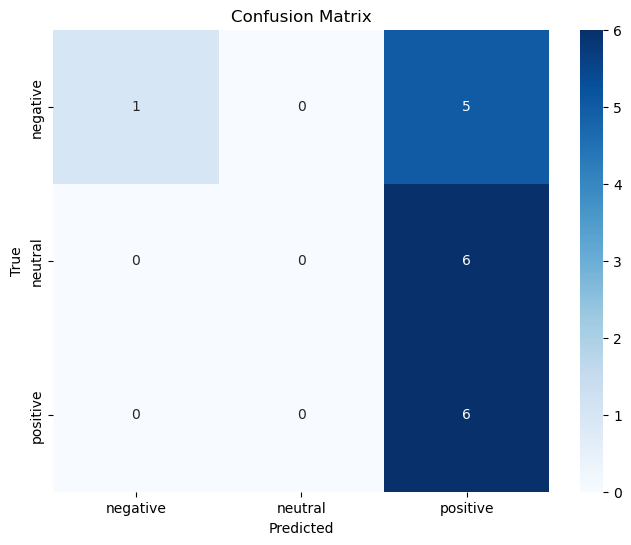

Precision: 0.4509803921568627
Recall: 0.3888888888888889
F1 Score: 0.2691511387163561
Accuracy: 0.3888888888888889


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Number of sentences with correct predictions: {comparison_df['comparison'].sum()}")

#Compute True Positive, True Negative, False Positive, False Negative
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Compute confusion matrix
cm = confusion_matrix(test_df['sentiment'], test_df['predicted_sentiment'], labels=['negative', 'neutral', 'positive'])
# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=['negative', 'neutral', 'positive'], columns=['negative', 'neutral', 'positive'])
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#Print precision, accuracy,recall and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
# Calculate precision, recall, and F1 score
precision = precision_score(test_df['sentiment'], test_df['predicted_sentiment'], average='weighted', labels=['negative', 'neutral', 'positive'])
recall = recall_score(test_df['sentiment'], test_df['predicted_sentiment'], average='weighted', labels=['negative', 'neutral', 'positive'])
f1 = f1_score(test_df['sentiment'], test_df['predicted_sentiment'], average='weighted', labels=['negative', 'neutral', 'positive'])
accuracy = accuracy_score(test_df['sentiment'], test_df['predicted_sentiment'])
# Print the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


ERROR ANALYSIS ON THE NAIVE BAYES MODEL

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Add a column indicating if prediction was correct ---
test_df['correct'] = test_df['sentiment'] == test_df['predicted_sentiment']

# --- Step 2: Print misclassified examples ---
misclassified_df = test_df[test_df['correct'] == False]
print("\n🔍 Sample Misclassified Reviews:")
print(misclassified_df[['sentence_id', 'sentence', 'sentiment', 'predicted_sentiment']].head(10))

# --- Step 3: Confusion matrix and report ---
print("\n📊 Classification Report:")
print(classification_report(test_df['sentiment'], test_df['predicted_sentiment'], digits=3))

print("\n📉 Confusion Matrix:")
conf_matrix = confusion_matrix(test_df['sentiment'], test_df['predicted_sentiment'], labels=['negative', 'neutral', 'positive'])
conf_df = pd.DataFrame(conf_matrix, index=['true_neg', 'true_neu', 'true_pos'], columns=['pred_neg', 'pred_neu', 'pred_pos'])
print(conf_df)

# --- Step 4: Most common mistakes ---
print("\n🔁 Top Confusion Pairs:")
confusion_pairs = misclassified_df.groupby(['sentiment', 'predicted_sentiment']).size().reset_index(name='count')
confusion_pairs = confusion_pairs.sort_values(by='count', ascending=False)
print(confusion_pairs.head(5))

# Show total number of errors
total_errors = len(test_df[test_df['comparison'] == False])
print(f"\nTotal Misclassified Examples: {total_errors}")

# Get only misclassified rows
misclassified_df = test_df[test_df['comparison'] == False]

# Show 5 examples for each type of confusion (actual vs predicted)
def show_errors(true_label, predicted_label, n=5):
    print(f"\n--- Examples where true label was '{true_label}' but predicted as '{predicted_label}' ---")
    subset = misclassified_df[
        (misclassified_df['sentiment'] == true_label) & 
        (misclassified_df['predicted_sentiment'] == predicted_label)
    ]
    for _, row in subset.head(n).iterrows():
        print(f"Sentence ID: {row['sentence_id']}")
        print(f"Sentence   : {row['sentence']}")
        print(f"True       : {row['sentiment']}")
        print(f"Predicted  : {row['predicted_sentiment']}")
        print('-' * 60)

# Define label combinations
labels = ['negative', 'neutral', 'positive']
for true in labels:
    for pred in labels:
        if true != pred:
            show_errors(true, pred)



🔍 Sample Misclassified Reviews:
    sentence_id                                           sentence sentiment  \
3             3  It’s more of a slow burn than a page-turner, b...   neutral   
4             4  It’s split into two timelines, which keeps it ...   neutral   
7             7  How do you concede three goals in ten minutes?...  negative   
8             8  They rotated their squad for the cup game, whi...   neutral   
9             9  The trailer gave away most of the plot, but th...   neutral   
10           10  The protagonist was so whiny I wanted to throw...  negative   
13           13  It's still 0-0 so far, so way too early to tel...   neutral   
14           14  I don't get the appeal at all, it's just a cou...  negative   
15           15  Did you hear the screenplay for it was origina...   neutral   
16           16  It's really incredibly impressive to mess up s...  negative   

   predicted_sentiment  
3             positive  
4             positive  
7          

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SENTIMENT ANALYSIS WITH BERT MODEL

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.83      0.83         6
     neutral       0.80      0.67      0.73         6
    positive       0.86      1.00      0.92         6

    accuracy                           0.83        18
   macro avg       0.83      0.83      0.83        18
weighted avg       0.83      0.83      0.83        18

Confusion Matrix:
[[5 1 0]
 [1 4 1]
 [0 0 6]]


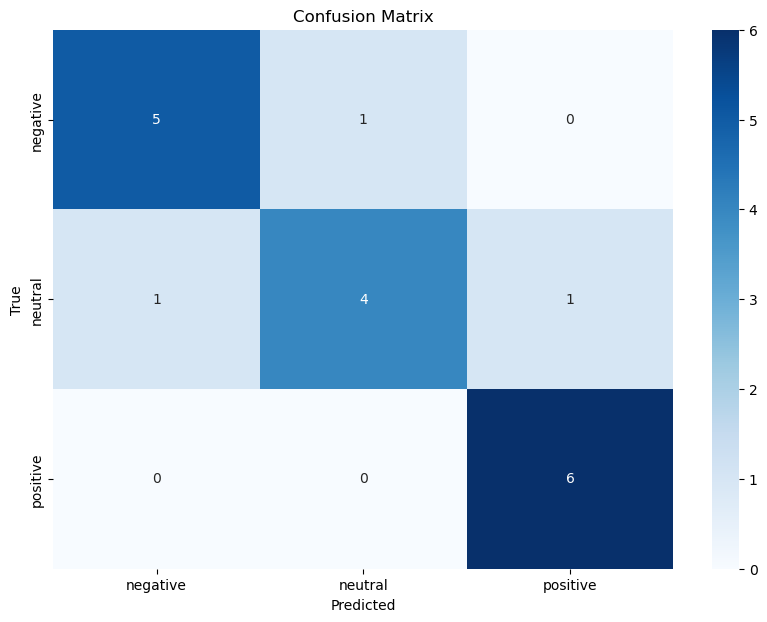

Accuracy: 0.8333
Precision: 0.8302
Recall: 0.8333
F1 Score: 0.8279


In [ ]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load 3-class sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)

# Define label map from model config
labels = ['negative', 'neutral', 'positive']

def extract_3way_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return labels[predicted_class]

# Apply to your cleaned review text
#df = pd.read_csv('/home/iason/Desktop/amazon_alexa.tsv', sep='\t')
#df['cleaned_review'] = df['verified_reviews'].apply(clean_text)

#df['sentiment'] = df['cleaned_review'].apply(extract_3way_sentiment)
sentiment_topic_test_df['sentiment_GROUP'] = sentiment_topic_test_df['cleaned_review'].apply(extract_3way_sentiment)

# Example output

#Compare the results with the original sentiment labels
sentiment_topic_test_df['sentiment'] = sentiment_topic_test_df['sentiment'].astype(str)
sentiment_topic_test_df['sentiment_GROUP'] = sentiment_topic_test_df['sentiment_GROUP'].astype(str)
#sentiment_topic_test_df['sentiment'] = sentiment_topic_test_df['sentiment'].astype(str)


#Add a column that says if we got the correct sentiment
sentiment_topic_test_df['correct'] = sentiment_topic_test_df['sentiment'] == sentiment_topic_test_df['sentiment_GROUP']
sentiment_topic_test_df

#Now calculate False Pasitive, False Negative, True Positive, True Negative Accuracy and F1 score and Precision
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd




# Calculate the confusion matrix
conf_matrix = confusion_matrix(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'])
# Calculate accuracy
accuracy = accuracy_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'])
# Calculate precision
precision = precision_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'], average='weighted')
# Calculate recall
recall = recall_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'], average='weighted')
# Calculate F1 score
f1 = f1_score(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP'], average='weighted')
# Print the classification report
print("Classification Report:")
print(classification_report(sentiment_topic_test_df['sentiment'], sentiment_topic_test_df['sentiment_GROUP']))
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Print the accuracy, precision, recall, and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
# Print the F1 score
print(f"F1 Score: {f1:.4f}")



ERROR ANALYSIS ON THE BERT MODEL FOR SENTIMENT ANALYSIS

In [ ]:
# Get incorrect predictions
sentiment_errors = sentiment_topic_test_df[sentiment_topic_test_df['correct'] == False]

# Show sample errors
print("Sample Sentiment Misclassifications:")
print(sentiment_errors[['cleaned_review', 'sentiment', 'sentiment_GROUP']].head(10))

# Count misclassified classes
error_counts = sentiment_errors.groupby(['sentiment', 'sentiment_GROUP']).size().reset_index(name='count')
print("\nConfused Sentiment Pairs (Top Confusions):")
print(error_counts.sort_values(by='count', ascending=False).head(10))



Sample Sentiment Misclassifications:
                                       cleaned_review sentiment  \
4   its split into two timelines which keeps it in...   neutral   
13  its still 00 so far so way too early to tell  ...   neutral   
17  the only way its helped me is by keeping my ta...  negative   

   sentiment_GROUP  
4         positive  
13        negative  
17         neutral  

Confused Sentiment Pairs (Top Confusions):
  sentiment sentiment_GROUP  count
0  negative         neutral      1
1   neutral        negative      1
2   neutral        positive      1


TOPIC ANALYSIS USING ZERO-SHOT-CLASSIFICATION

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


Topic Classification Report:
              precision    recall  f1-score   support

        book       1.00      0.67      0.80         6
       movie       0.75      1.00      0.86         6
      sports       1.00      1.00      1.00         6

    accuracy                           0.89        18
   macro avg       0.92      0.89      0.89        18
weighted avg       0.92      0.89      0.89        18

Topic Confusion Matrix:
[[4 2 0]
 [0 6 0]
 [0 0 6]]


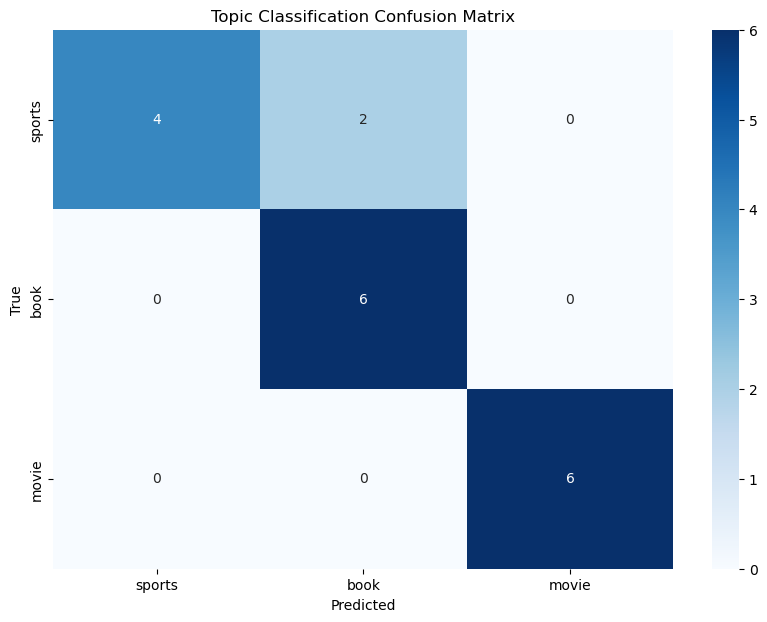

Topic Classification Accuracy: 0.8889
Topic Classification Precision: 0.9167
Topic Classification Recall: 0.8889
Topic Classification F1 Score: 0.8857


In [ ]:
from transformers import pipeline
import pandas as pd

# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Load your dataframe (assuming it's already loaded as sentiment_topic_test_df)
df = sentiment_topic_test_df

# List of candidate topics (single words in this case)
candidate_topics = ['sports', 'book', 'movie']

# Function to predict topic for each sentence
def extract_predicted_topic(text):
    result = classifier(text, candidate_labels=candidate_topics)
    # Extract the most likely topic (the one with the highest score)
    predicted_topic = result['labels'][0]  # The first label is the most likely topic
    return predicted_topic

# Apply the function to the 'cleaned_review' column to extract topics
df['predicted_topic'] = df['cleaned_review'].apply(extract_predicted_topic)

# Show the results
df.head()

# Example output - compare predicted topics with true topics if available
# Assuming 'topic' column holds true topic labels
df['topic'] = df['topic'].astype(str)  # Assuming 'topic' is the true label column
df['predicted_topic'] = df['predicted_topic'].astype(str)

# Add a column to check if we got the correct topic prediction
df['correct_topic'] = df['topic'] == df['predicted_topic']

# Now calculate metrics for topic classification
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

conf_matrix_topic = confusion_matrix(df['topic'], df['predicted_topic'])
accuracy_topic = accuracy_score(df['topic'], df['predicted_topic'])
precision_topic = precision_score(df['topic'], df['predicted_topic'], average='weighted')
recall_topic = recall_score(df['topic'], df['predicted_topic'], average='weighted')
f1_topic = f1_score(df['topic'], df['predicted_topic'], average='weighted')

# Print the classification report for topics
print("Topic Classification Report:")
print(classification_report(df['topic'], df['predicted_topic']))

# Print the confusion matrix for topics
print("Topic Confusion Matrix:")
print(conf_matrix_topic)

# Plot the confusion matrix for topics
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_topic, annot=True, fmt='d', cmap='Blues', xticklabels=candidate_topics, yticklabels=candidate_topics)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Topic Classification Confusion Matrix')
plt.show()

# Print the accuracy, precision, recall, and F1 score for topics
print(f"Topic Classification Accuracy: {accuracy_topic:.4f}")
print(f"Topic Classification Precision: {precision_topic:.4f}")
print(f"Topic Classification Recall: {recall_topic:.4f}")
print(f"Topic Classification F1 Score: {f1_topic:.4f}")


ERROR ANALYSIS ON THE TOPIC CLASSIFICATION MODEL

In [ ]:
# Qualitative Error Analysis for Topic Modeling

# Filter wrong predictions
wrong_predictions_df = df[df['correct_topic'] == False]

# Display examples of errors
print("\nExamples of Wrong Predictions:")
print(wrong_predictions_df[['cleaned_review', 'topic', 'predicted_topic']])

# Optionally, save them to a CSV to review later
wrong_predictions_df.to_csv('topic_modeling_errors.csv', index=False)

# Show some statistics about where the model struggled most
error_counts = wrong_predictions_df.groupby(['topic', 'predicted_topic']).size().reset_index(name='count')
print("\nMost Common Misclassifications:")
print(error_counts.sort_values(by='count', ascending=False))



Examples of Wrong Predictions:
                                       cleaned_review topic predicted_topic
4   its split into two timelines which keeps it in...  book           movie
17  the only way its helped me is by keeping my ta...  book           movie

Most Common Misclassifications:
  topic predicted_topic  count
0  book           movie      2
